In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# Pytorch Setup

In [18]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


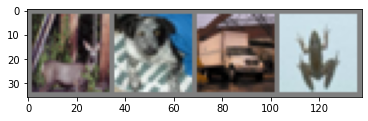

deer  dog   truck frog 


In [19]:

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



In [20]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Question 11: Hyperparameter Tuning



In [98]:

# Hyperparameter Tuning: Question 11

learning_rate = [0.0005, 0.001, 0.01]
momentum = [0.9, 0.95]


###Define the grid of parameters to search
hyper_grid = {'learning_rate': learning_rate,
              'momentum': momentum}

hpts = ParameterGrid(hyper_grid)

results_dict_tune = {}


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for param_run, params in enumerate(hpts):
    
    lr = params['learning_rate']
    mom = params['momentum']
    net = Net()
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mom)

    loss_list = list()

    for epoch in range(10): 

        for i, data in tqdm(enumerate(trainloader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

            # print statistics
    
    correct_train = 0
    total_train = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
    train_acc = correct_train / total_train
    
    correct_val = 0
    total_val = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_acc = correct_val / total_val

    print(f'Training Accuracy with lr {lr} and mom {mom}: {train_acc}')
    print(f'Validation Accuracy with lr {lr} and mom {mom}: {val_acc}')

    results_dict_tune[param_run] = [train_acc, val_acc, loss_list]

print('Finished Training')

with open('/content/gdrive/My Drive/tuning_results.pkl', 'wb') as f:
    pickle.dump(results_dict_tune, f)


12500it [00:59, 211.01it/s]
12500it [00:59, 211.82it/s]
12500it [00:56, 219.69it/s]
12500it [00:57, 217.08it/s]
12500it [00:57, 218.15it/s]
12500it [00:57, 217.82it/s]
12500it [00:56, 220.18it/s]
12500it [00:57, 217.92it/s]
12500it [00:56, 220.15it/s]
12500it [00:57, 216.94it/s]


Training Accuracy with lr 0.0005 and mom 0.9: 0.70764
Validation Accuracy with lr 0.0005 and mom 0.9: 0.6159


12500it [00:57, 216.53it/s]
12500it [00:56, 220.34it/s]
12500it [00:57, 219.11it/s]
12500it [00:56, 222.36it/s]
12500it [00:57, 216.78it/s]
12500it [00:56, 221.35it/s]
12500it [00:57, 218.15it/s]
12500it [00:57, 216.45it/s]
12500it [00:56, 221.74it/s]
12500it [00:56, 220.40it/s]


Training Accuracy with lr 0.0005 and mom 0.95: 0.74212
Validation Accuracy with lr 0.0005 and mom 0.95: 0.6259


12500it [00:56, 219.44it/s]
12500it [00:56, 222.27it/s]
12500it [00:56, 222.27it/s]
12500it [00:56, 220.93it/s]
12500it [00:57, 217.37it/s]
12500it [00:56, 222.97it/s]
12500it [00:55, 223.87it/s]
12500it [00:56, 220.36it/s]
12500it [00:57, 219.01it/s]
12500it [00:55, 223.67it/s]


Training Accuracy with lr 0.001 and mom 0.9: 0.74688
Validation Accuracy with lr 0.001 and mom 0.9: 0.6327


12500it [00:56, 220.68it/s]
12500it [00:56, 219.63it/s]
12500it [00:55, 224.09it/s]
12500it [00:55, 223.26it/s]
12500it [00:56, 221.10it/s]
12500it [00:56, 219.76it/s]
12500it [00:55, 224.21it/s]
12500it [00:55, 223.25it/s]
12500it [00:56, 222.95it/s]
12500it [00:56, 221.87it/s]


Training Accuracy with lr 0.001 and mom 0.95: 0.69408
Validation Accuracy with lr 0.001 and mom 0.95: 0.5988


12500it [00:56, 221.08it/s]
12500it [00:56, 222.36it/s]
12500it [00:55, 225.44it/s]
12500it [00:55, 225.53it/s]
12500it [00:57, 217.36it/s]
12500it [00:56, 222.17it/s]
12500it [00:55, 224.63it/s]
12500it [00:55, 224.39it/s]
12500it [00:56, 219.41it/s]
12500it [00:55, 224.88it/s]


Training Accuracy with lr 0.01 and mom 0.9: 0.24822
Validation Accuracy with lr 0.01 and mom 0.9: 0.2438


12500it [00:56, 221.61it/s]
12500it [00:57, 218.73it/s]
12500it [00:56, 223.02it/s]
12500it [00:55, 224.26it/s]
12500it [00:55, 225.80it/s]
12500it [00:55, 225.22it/s]
12500it [00:55, 224.29it/s]
12500it [00:57, 218.02it/s]
12500it [00:55, 226.33it/s]
12500it [00:56, 219.78it/s]


Training Accuracy with lr 0.01 and mom 0.95: 0.1
Validation Accuracy with lr 0.01 and mom 0.95: 0.1
Finished Training


<function matplotlib.pyplot.show(*args, **kw)>

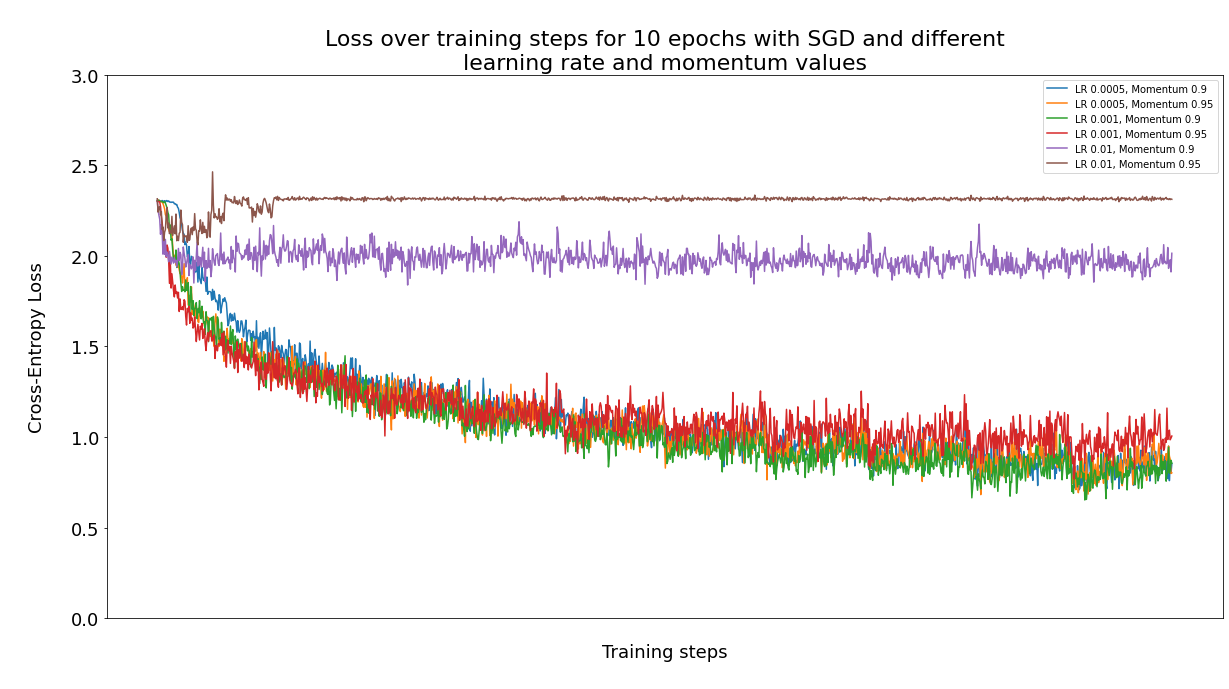

In [45]:
# Visualization of Momentum and Learning Rate Tuning

with open('/content/gdrive/My Drive/tuning_results.pkl', 'rb') as f:
    results_dict_tune = pickle.load(f)

epochs = 10
window_size = 100
lr_histories = list()
#lr_histories = np.zeros((1249,0))

for i in range(6):
    loss_history = results_dict_tune[i][2]
    windows = [loss_history[i:i+window_size] for i in range(0,len(loss_history)-window_size, window_size)]
    loss_avg = [sum(window)/window_size for window in windows]
    #lr_histories = np.hstack((lr_histories, np.array(loss_avg)[:,np.newaxis]))
    lr_histories.append(loss_avg)


plt.figure(figsize=(20,10))

plt.plot(lr_histories[0],label = "LR 0.0005, Momentum 0.9")
plt.plot(lr_histories[1],label = "LR 0.0005, Momentum 0.95")
plt.plot(lr_histories[2],label = "LR 0.001, Momentum 0.9")
plt.plot(lr_histories[3],label = "LR 0.001, Momentum 0.95")
plt.plot(lr_histories[4],label = "LR 0.01, Momentum 0.9")
plt.plot(lr_histories[5],label = "LR 0.01, Momentum 0.95")
plt.legend()
ticks = [i for i in range(len(trainset)*epochs, 10000)]
plt.xticks(ticks = ticks, labels = [tick for tick in ticks], size = 18, rotation = 45)
plt.yticks(size = 18)
plt.ylim(0, 3)
plt.title("\n Loss over training steps for 10 epochs with SGD and different \nlearning rate and momentum values", size = 22)
plt.ylabel("\nCross-Entropy Loss\n", size = 18)
plt.xlabel("\nTraining steps\n", size = 18)
plt.show

# Question 12: Network Architecture Experiments


In [131]:
# Changing Architecture / Concept: Question 12

# Adding Dropout
# Adding Layers
# Adding Residual Connection

results_dict_exp = {}

for param_run, params in enumerate((("adam", True, 0.1), ("sgd", True, 0.1), ("adam", False, 0.1), ("sgd", False, 0.1), ("adam", True, 0.3), ("sgd", True, 0.3), ("adam", False, 0.3), ("sgd", False, 0.3))):

  opt = params[0]
  residual = params[1]
  dropout = params[2]

  loss_list = list()

  class Adapt_Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 6, 5)
          self.pool = nn.MaxPool2d(2, 2)
          self.conv2 = nn.Conv2d(6, 16, 5, 1, 1)
          self.conv3 = nn.Conv2d(16, 16, 5, 1, 2) # Added layer
          self.batchnorm_1 = nn.BatchNorm1d(576)
          self.fc1 = nn.Linear(16 * 6 * 6, 120)
          self.dropout = nn.Dropout(dropout) # Added Dropout
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, 10)

      def forward(self, x):
          x_1 = self.pool(F.relu(self.conv1(x)))
          x_2 = self.pool(F.relu(self.conv2(x_1)))# Residual connection by adding x_1, that skipped the second conv layer
          x_3 = F.relu(self.conv3(x_2))

          if residual:
            x = x_2 + x_3 # Residual connection
          else:
            x = x_3

          x = torch.flatten(x, 1) # flatten all dimensions except batch, seperately for the last two Conv layers
          x = F.relu(self.fc1(x)) # Another residual connection, by skipping the 4th convolutional layer (x_f1 did not pass through self.conv4 but x_f2 did)
          x = self.dropout(x) # Adding Dropout of 20 %
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x


  net = Adapt_Net()
  net.to(device)

  criterion = nn.CrossEntropyLoss()

  if opt == "adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


  for epoch in range(10): 

      running_correct = 0
      running_total = 0
      for i, data in tqdm(enumerate(trainloader, 0)):
          # get the inputs; data is a list of [inputs, labels]
          
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())
          loss.backward()
          optimizer.step()

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          running_total += labels.size(0)
          running_correct += (predicted == labels).sum().item()
          
      
      print(f"Train accuracy after epoch {epoch}: {running_correct / running_total}")
      
  correct_train = 0
  total_train = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in trainloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()
          
  train_acc = correct_train / total_train

  correct_val = 0
  total_val = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

  val_acc = correct_val / total_val

  results_dict_exp[param_run] = [train_acc, val_acc, loss_list]

  print(f'Training Accuracy with {params}: {train_acc}')
  print(f'Validation Accuracy with {params}: {val_acc}')


with open('/content/gdrive/My Drive/exp_results.pkl', 'wb') as f:
    pickle.dump(results_dict_exp, f)



12500it [01:18, 159.63it/s]

Train accuracy after epoch 0: 0.43824



12500it [01:15, 166.53it/s]

Train accuracy after epoch 1: 0.54586



12500it [01:13, 168.92it/s]

Train accuracy after epoch 2: 0.58294



12500it [01:14, 168.24it/s]

Train accuracy after epoch 3: 0.60868



12500it [01:15, 164.96it/s]

Train accuracy after epoch 4: 0.62376



12500it [01:13, 170.69it/s]

Train accuracy after epoch 5: 0.63614



12500it [01:13, 170.10it/s]

Train accuracy after epoch 6: 0.64628



12500it [01:14, 168.36it/s]

Train accuracy after epoch 7: 0.65872



12500it [01:15, 165.31it/s]

Train accuracy after epoch 8: 0.66394



12500it [01:12, 171.87it/s]

Train accuracy after epoch 9: 0.66772


Training Accuracy with ('adam', True, 0.1): 0.6851
Validation Accuracy with ('adam', True, 0.1): 0.6096


12500it [01:02, 198.74it/s]

Train accuracy after epoch 0: 0.38044



12500it [01:02, 198.63it/s]

Train accuracy after epoch 1: 0.5278



12500it [01:04, 192.69it/s]

Train accuracy after epoch 2: 0.58068



12500it [01:02, 199.94it/s]

Train accuracy after epoch 3: 0.6128



12500it [01:02, 200.16it/s]

Train accuracy after epoch 4: 0.63826



12500it [01:02, 201.47it/s]

Train accuracy after epoch 5: 0.65986



12500it [01:02, 199.75it/s]

Train accuracy after epoch 6: 0.6777



12500it [01:04, 194.12it/s]

Train accuracy after epoch 7: 0.68854



12500it [01:01, 201.69it/s]

Train accuracy after epoch 8: 0.69946



12500it [01:01, 202.28it/s]

Train accuracy after epoch 9: 0.71036


Training Accuracy with ('sgd', True, 0.1): 0.7477
Validation Accuracy with ('sgd', True, 0.1): 0.632


12500it [01:11, 175.21it/s]

Train accuracy after epoch 0: 0.41536



12500it [01:12, 171.86it/s]

Train accuracy after epoch 1: 0.51628



12500it [01:10, 177.73it/s]

Train accuracy after epoch 2: 0.55278



12500it [01:10, 176.23it/s]

Train accuracy after epoch 3: 0.57596



12500it [01:10, 176.66it/s]

Train accuracy after epoch 4: 0.59068



12500it [01:12, 172.14it/s]

Train accuracy after epoch 5: 0.60924



12500it [01:10, 177.91it/s]

Train accuracy after epoch 6: 0.61818



12500it [01:10, 177.49it/s]

Train accuracy after epoch 7: 0.62744



12500it [01:10, 176.95it/s]

Train accuracy after epoch 8: 0.6369



12500it [01:11, 175.61it/s]

Train accuracy after epoch 9: 0.64394


Training Accuracy with ('adam', False, 0.1): 0.66202
Validation Accuracy with ('adam', False, 0.1): 0.5844


12500it [01:00, 205.25it/s]

Train accuracy after epoch 0: 0.32898



12500it [01:01, 203.84it/s]

Train accuracy after epoch 1: 0.49746



12500it [01:02, 200.65it/s]

Train accuracy after epoch 2: 0.56338



12500it [01:03, 197.30it/s]

Train accuracy after epoch 3: 0.60256



12500it [01:04, 194.74it/s]

Train accuracy after epoch 4: 0.62638



12500it [01:01, 204.65it/s]

Train accuracy after epoch 5: 0.64682



12500it [01:01, 203.14it/s]

Train accuracy after epoch 6: 0.6622



12500it [01:00, 205.02it/s]

Train accuracy after epoch 7: 0.67356



12500it [01:01, 202.77it/s]

Train accuracy after epoch 8: 0.68456



12500it [01:02, 198.58it/s]

Train accuracy after epoch 9: 0.691


Training Accuracy with ('sgd', False, 0.1): 0.7142
Validation Accuracy with ('sgd', False, 0.1): 0.6108


12500it [01:10, 176.74it/s]

Train accuracy after epoch 0: 0.40902



12500it [01:10, 176.49it/s]

Train accuracy after epoch 1: 0.49834



12500it [01:13, 169.38it/s]

Train accuracy after epoch 2: 0.5356



12500it [01:10, 177.11it/s]

Train accuracy after epoch 3: 0.55816



12500it [01:10, 177.11it/s]

Train accuracy after epoch 4: 0.57366



12500it [01:11, 175.07it/s]

Train accuracy after epoch 5: 0.58534



12500it [01:13, 170.29it/s]

Train accuracy after epoch 6: 0.59858



12500it [01:10, 177.40it/s]

Train accuracy after epoch 7: 0.60712



12500it [01:11, 175.77it/s]

Train accuracy after epoch 8: 0.61438



12500it [01:11, 176.00it/s]

Train accuracy after epoch 9: 0.62108


Training Accuracy with ('adam', True, 0.3): 0.64008
Validation Accuracy with ('adam', True, 0.3): 0.582


12500it [01:02, 198.67it/s]

Train accuracy after epoch 0: 0.3638



12500it [01:01, 204.11it/s]

Train accuracy after epoch 1: 0.51016



12500it [01:01, 203.48it/s]

Train accuracy after epoch 2: 0.5657



12500it [01:02, 201.49it/s]

Train accuracy after epoch 3: 0.59558



12500it [01:03, 196.04it/s]

Train accuracy after epoch 4: 0.6191



12500it [01:01, 201.89it/s]

Train accuracy after epoch 5: 0.63454



12500it [01:01, 204.14it/s]

Train accuracy after epoch 6: 0.64798



12500it [01:01, 203.01it/s]

Train accuracy after epoch 7: 0.65844



12500it [01:01, 203.20it/s]

Train accuracy after epoch 8: 0.66756



12500it [01:03, 196.20it/s]

Train accuracy after epoch 9: 0.6768


Training Accuracy with ('sgd', True, 0.3): 0.6907
Validation Accuracy with ('sgd', True, 0.3): 0.6248


12500it [01:10, 176.54it/s]

Train accuracy after epoch 0: 0.39512



12500it [01:10, 176.61it/s]

Train accuracy after epoch 1: 0.5104



12500it [01:12, 173.28it/s]

Train accuracy after epoch 2: 0.54578



12500it [01:10, 177.71it/s]

Train accuracy after epoch 3: 0.56572



12500it [01:10, 176.54it/s]

Train accuracy after epoch 4: 0.58462



12500it [01:10, 178.38it/s]

Train accuracy after epoch 5: 0.59322



12500it [01:12, 172.12it/s]

Train accuracy after epoch 6: 0.60574



12500it [01:10, 177.16it/s]

Train accuracy after epoch 7: 0.60738



12500it [01:10, 176.34it/s]

Train accuracy after epoch 8: 0.61508



12500it [01:09, 178.62it/s]

Train accuracy after epoch 9: 0.62


Training Accuracy with ('adam', False, 0.3): 0.63026
Validation Accuracy with ('adam', False, 0.3): 0.5742


12500it [01:01, 204.61it/s]

Train accuracy after epoch 0: 0.30006



12500it [01:00, 204.95it/s]

Train accuracy after epoch 1: 0.48848



12500it [01:01, 203.35it/s]

Train accuracy after epoch 2: 0.54934



12500it [01:03, 196.55it/s]

Train accuracy after epoch 3: 0.58258



12500it [01:00, 205.01it/s]

Train accuracy after epoch 4: 0.60432



12500it [01:01, 204.78it/s]


Train accuracy after epoch 5: 0.62248


12500it [01:01, 204.63it/s]

Train accuracy after epoch 6: 0.63362



12500it [01:01, 202.56it/s]

Train accuracy after epoch 7: 0.64238



12500it [01:03, 197.68it/s]

Train accuracy after epoch 8: 0.6516



12500it [01:01, 203.04it/s]

Train accuracy after epoch 9: 0.6577


Training Accuracy with ('sgd', False, 0.3): 0.6785
Validation Accuracy with ('sgd', False, 0.3): 0.6121


<function matplotlib.pyplot.show(*args, **kw)>

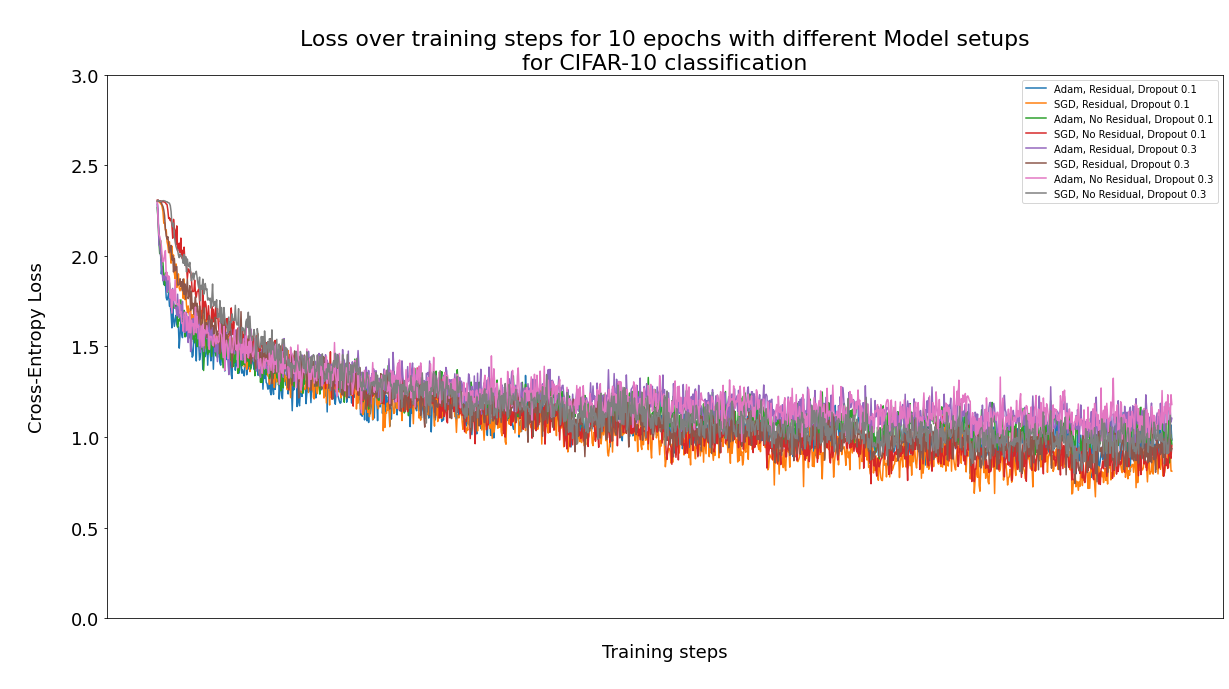

In [51]:
# Visualization of Momentum and Learning Rate Tuning

with open('/content/gdrive/My Drive/exp_results.pkl', 'rb') as f:
    results_dict_exp = pickle.load(f)

epochs = 10
window_size = 100
lr_histories = list()

for i in range(8):
    loss_history = results_dict_exp[i][2]
    windows = [loss_history[i:i+window_size] for i in range(0,len(loss_history)-window_size, window_size)]
    loss_avg = [sum(window)/window_size for window in windows]
    lr_histories.append(loss_avg)


plt.figure(figsize=(20,10))

plt.plot(lr_histories[0],label = "Adam, Residual, Dropout 0.1")
plt.plot(lr_histories[1],label = "SGD, Residual, Dropout 0.1")
plt.plot(lr_histories[2],label = "Adam, No Residual, Dropout 0.1")
plt.plot(lr_histories[3],label = "SGD, No Residual, Dropout 0.1")
plt.plot(lr_histories[4],label = "Adam, Residual, Dropout 0.3")
plt.plot(lr_histories[5],label = "SGD, Residual, Dropout 0.3")
plt.plot(lr_histories[6],label = "Adam, No Residual, Dropout 0.3")
plt.plot(lr_histories[7],label = "SGD, No Residual, Dropout 0.3")
plt.legend()
ticks = [i for i in range(len(trainset)*1, 10000)]
plt.xticks(ticks = ticks, labels = [tick for tick in ticks], size = 18, rotation = 45)
plt.yticks(size = 18)
plt.ylim(0, 3)
plt.title("\n Loss over training steps for 10 epochs with different Model setups \nfor CIFAR-10 classification", size = 22)
plt.ylabel("\nCross-Entropy Loss\n", size = 18)
plt.xlabel("\nTraining steps\n", size = 18)
plt.show